In [1]:
%load_ext autoreload
%autoreload 2

import ipywidgets as widgets
import numpy as np
import os
import pandas as pd

from benchmarks import gsa_svm_fitness
from src.entities import GSA

from IPython.display import display
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from typing import Mapping, Tuple, Union
from ucimlrepo import fetch_ucirepo

In [2]:
uci_datasets = ["Breast Cancer Wisconsin (Diagnostic)",
                "Spambase",
                "Mushroom"]

widget_opt = widgets.Dropdown(
    options=uci_datasets,
    description='Dataset: '
)

display(widget_opt)



Dropdown(description='Dataset: ', options=('Breast Cancer Wisconsin (Diagnostic)', 'Spambase', 'Mushroom'), va…

In [3]:
def fetch_categorical_dataset(_id: int) -> Tuple[pd.DataFrame, pd.Series]:
    data = fetch_ucirepo(id=_id)
    X = data.data.features
    y = data.data.targets
    encoder = LabelEncoder()
    for col in X.columns:
        X.loc[:, col] = encoder.fit_transform(X[col])
    return X, y

if widget_opt.value == "Breast Cancer Wisconsin (Diagnostic)":
    data = fetch_ucirepo(id=15)
    X = data.data.features
    y = data.data.targets
    X = X.fillna(value=0)
elif widget_opt.value == "Spambase":
    X, y = fetch_categorical_dataset(_id=94)
elif widget_opt.value == "Mushroom":
    X, y = fetch_categorical_dataset(_id=73)
    
# Name of selected dataset and summary (number of instances, features, etc.)
print(f"Dataset: {widget_opt.value}")
print(f"Instances: {X.shape[0]} (Train / Test: 80% / 20%)")
print(f"Features: {X.shape[1]}")

Dataset: Breast Cancer Wisconsin (Diagnostic)
Instances: 699 (Train / Test: 80% / 20%)
Features: 9


In [4]:
# IMPORTANT!! GLOBAL VARIABLES
wa = 0.8
wf = 0.2

# IMPORTANT!! MUTABLE GLOBAL VARIABLE
conf_matrix_dict = {"TP": 0, "FP": 0, "TN": 0, "FN": 0}

class UCI:
    """
    Class to handle UCI datasets
    
    Args:
        X (pd.DataFrame): Features
        y (pd.Series): Target
    """
    def __init__(self,
                 X: pd.DataFrame,
                 y: pd.Series,
                 boundaries: Mapping[str, Tuple[Tuple[float, float], ...]],
                 seed: int = 5
                 ) -> None:
        """
        Constructor
        
        Args:
            X (pd.DataFrame): Features
            y (pd.Series): Target
            boundaries (Mapping[str, Tuple[Tuple[float, float], ...]): Boundaries for the optimization problem
            seed (int, optional): Random seed. Defaults to 5.
        """
        self.X = X
        self.y = y
        self.boundaries = boundaries

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X)
        
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.20, random_state=seed)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    
    def get_fitness(self,
                    solution: Mapping[str, np.ndarray],
                    data: Union[None, Tuple[np.ndarray, np.ndarray]] = None,
                    show_confusion_matrix: bool=False
                    ) -> Tuple[float, float]:
        """
        Get fitness of a solution
        
        Args:
            solution (Mapping[str, np.ndarray]): Solution to evaluate
            data (Union[None, Tuple[np.ndarray, np.ndarray]], optional): Data to evaluate the solution. Defaults to None.
        
        Returns:
            Tuple[float, float]: Fitness and accuracy of the solution    
        """
        if data is None:
            X_scaled = self.X_train
            y_data = self.y_train
        else:
            X_scaled, y_data = data
            
        gamma, C = solution['real']
        gamma /= 1_000
        C /= 1_000
        X_scaled_filtered = X_scaled[:, solution['discrete'].astype(int) == 1]
        svc_model = SVC(gamma=gamma, C=C, kernel="rbf", verbose=False)
        svc_model.fit(X_scaled_filtered, np.ravel(y_data))
        y_predict = svc_model.predict(X_scaled_filtered)
        conf_matrix = confusion_matrix(y_data, y_predict)
        if show_confusion_matrix:
            # Update global conf_matrix_dict
            conf_matrix_dict["TP"] = conf_matrix[0, 0]
            conf_matrix_dict["FP"] = conf_matrix[0, 1]
            conf_matrix_dict["TN"] = conf_matrix[1, 1]
            conf_matrix_dict["FN"] = conf_matrix[1, 0]
            print(conf_matrix)
        accuracy = accuracy_score(y_data, y_predict) * 100
        
        return gsa_svm_fitness(accuracy=accuracy, solution=solution, wa=wa, wf=wf)

    def is_feasible(self, solution: Mapping[str, np.ndarray]) -> bool:
        """
        Check if a solution is feasable

        Args:
            solution (Mapping[str, np.ndarray]): Solution to evaluate

        Returns:
            bool: True if the solution is feasable, False otherwise
        """
        real_values = solution['real']
        discrete_values = solution['discrete']

        for i, (min_val, max_val) in enumerate(self.boundaries['real']):
            if real_values[i] < min_val or real_values[i] > max_val:
                return False

        for i, (min_val, max_val) in enumerate(self.boundaries['discrete']):
            if discrete_values[i] < min_val or discrete_values[i] > max_val:
                return False
        
        if sum(discrete_values) == 0:
            return False
        
        return True

boundaries = {'real': [(1, 100_000), (1, 100_000)], 'discrete': [(0, 1) for _ in range(len(X.columns))]}
uci = UCI(X, y, boundaries)

In [21]:
# Select number of repetitions for each experiment. 
runs = 10

population_size = 5 
iterations = 20

chaotic_constant=True
repair_solution=False

gsa_history_dict = {"best_solution_history": [],
                    "accuracy_history": [],
                    "gamma_history": [],
                    "c_history": [],
                    "n_features_history": [],
                    "execution_time_history": [],
                    "TP_history": [],
                    "FP_history": [],
                    "TN_history": [],
                    "FN_history": []}

uci = UCI(X, y, boundaries)

global_train_hist = pd.DataFrame()
global_test_hist = pd.DataFrame(columns=["run", "accuracy", "fitness", "TP", "FP", "TN", "FN"])

for k in range(runs):
    gsa_algo = GSA(objective_function = uci.get_fitness,
                   is_feasible=uci.is_feasible,
                   r_dim=2,
                   d_dim=len(X.columns),
                   boundaries=uci.boundaries)
    
    training_history = gsa_algo.optimize(population_size=population_size,
                                iters=iterations,
                                chaotic_constant=chaotic_constant,
                                repair_solution=repair_solution)
    
    training_history.insert(0, "run", k)
    global_train_hist = pd.concat([global_train_hist, training_history], axis=0)
    
    print(gsa_algo.solution_history[-1])
    fitness, accuracy = uci.get_fitness(solution=gsa_algo.solution_history[-1],
                                        data=(uci.X_test, uci.y_test),
                                        show_confusion_matrix=True)
    
    global_test_hist.loc[len(global_test_hist)] = [k, accuracy, fitness, conf_matrix_dict["TP"], conf_matrix_dict["FP"], conf_matrix_dict["TN"], conf_matrix_dict["FN"]]
    
    print("Test accuracy: ", accuracy, " - Fitness: ", fitness)
    
    gsa_history_dict["best_solution_history"].append(gsa_algo.solution_history[-1])
    gsa_history_dict["accuracy_history"].append(accuracy)
    gsa_history_dict["gamma_history"].append(gsa_algo.solution_history[-1]['real'][0] / 1_000)
    gsa_history_dict["c_history"].append(gsa_algo.solution_history[-1]['real'][1] / 1_000)
    gsa_history_dict["n_features_history"].append(np.sum(gsa_algo.solution_history[-1]['discrete']))
    gsa_history_dict["execution_time_history"].append(gsa_algo.execution_time)
    gsa_history_dict["TP_history"].append(conf_matrix_dict["TP"])
    gsa_history_dict["FP_history"].append(conf_matrix_dict["FP"])
    gsa_history_dict["TN_history"].append(conf_matrix_dict["TN"])
    gsa_history_dict["FN_history"].append(conf_matrix_dict["FN"])

GSA is optimizing  "get_fitness"
['At iteration 1 the best fitness is 88.88888888888889']
['At iteration 2 the best fitness is 91.47286821705427']
['At iteration 3 the best fitness is 92.47465712581993']
['At iteration 4 the best fitness is 92.47465712581993']
['At iteration 5 the best fitness is 92.47465712581993']
['At iteration 6 the best fitness is 92.47465712581993']
['At iteration 7 the best fitness is 92.47465712581993']
['At iteration 8 the best fitness is 92.47465712581993']
['At iteration 9 the best fitness is 92.47465712581993']
['At iteration 10 the best fitness is 92.47465712581993']
['At iteration 11 the best fitness is 92.47465712581993']
['At iteration 12 the best fitness is 92.47465712581993']
['At iteration 13 the best fitness is 92.47465712581993']
['At iteration 14 the best fitness is 92.47465712581993']
['At iteration 15 the best fitness is 92.47465712581993']
['At iteration 16 the best fitness is 92.47465712581993']
['At iteration 17 the best fitness is 92.4746571

In [6]:
global_train_hist

,run,Iteration,Fitness,Accuracy,ExecutionTime,Discrete,Real
0,0,0,91.111111,100.000000,0.041841,"[[1, 0, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, ...","[[13881.06865226167, 29800.62360256229], [6372..."
1,0,1,92.617770,99.105546,0.078238,"[[1, 0, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, ...","[[13881.06865226167, 29800.62360256229], [6372..."
2,0,2,92.617770,99.105546,0.111841,"[[1, 0, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, ...","[[13881.06865226167, 29800.62360256229], [6372..."
3,0,3,93.047108,99.642218,0.143500,"[[1, 0, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, ...","[[13881.06865226167, 29800.62360256229], [6372..."
4,0,4,93.047108,99.642218,0.183029,"[[1, 0, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, ...","[[13881.06865226167, 29800.62360256229], [6372..."
...,...,...,...,...,...,...,...
15,9,15,93.190221,99.821109,0.441622,"[[0, 1, 0, 0, 0, 1, 0, 1, 0], [0, 1, 0, 0, 0, ...","[[27617.23026381947, 16472.86717390901], [1140..."
16,9,16,93.190221,99.821109,0.466281,"[[0, 1, 0, 0, 0, 1, 0, 1, 0], [0, 1, 0, 0, 0, ...","[[27617.23026381947, 16472.86717390901], [1140..."
17,9,17,93.190221,99.821109,0.491388,"[[0, 1, 0, 0, 0, 1, 0, 1, 0], [0, 1, 0, 0, 0, ...","[[27617.23026381947, 16472.86717390901], [1140..."
18,9,18,93.190221,99.821109,0.515204,"[[0, 1, 0, 0, 0, 1, 0, 1, 0], [0, 1, 0, 0, 0, ...","[[27617.23026381947, 16472.86717390901], [1140..."


In [7]:
global_test_hist

,run,accuracy,fitness,TP,FP,TN,FN
0,0.0,97.142857,93.269841,88.0,3.0,48.0,1.0
1,1.0,100.000000,91.111111,91.0,0.0,49.0,0.0
2,2.0,100.000000,91.111111,91.0,0.0,49.0,0.0
3,3.0,97.857143,93.841270,88.0,3.0,49.0,0.0
4,4.0,99.285714,92.761905,91.0,0.0,48.0,1.0
5,5.0,99.285714,92.761905,90.0,1.0,49.0,0.0
6,6.0,99.285714,90.539683,90.0,1.0,49.0,0.0
7,7.0,99.285714,90.539683,91.0,0.0,48.0,1.0
8,8.0,100.000000,88.888889,91.0,0.0,49.0,0.0
9,9.0,98.571429,92.190476,89.0,2.0,49.0,0.0


In [12]:
sns_test_df = pd.DataFrame(columns=["run", "iter", "accuracy", "fitness"])

for r in range(runs):
    acc = 5
    fit = 4
    for i in range(20):
        sns_test_df.loc[len(sns_test_df)] = [r, i, acc - 4 * np.random.rand(), fit - 4 * np.random.rand()]
        acc += 5
        fit += 3

sns_test_df

,run,iter,accuracy,fitness
0,0.0,0.0,4.411189,0.242164
1,0.0,1.0,9.279370,5.128058
2,0.0,2.0,14.216532,8.956937
3,0.0,3.0,18.832334,9.146539
4,0.0,4.0,23.739020,15.625738
...,...,...,...,...
195,9.0,15.0,79.207582,48.379732
196,9.0,16.0,84.212889,49.879659
197,9.0,17.0,87.202828,53.774603
198,9.0,18.0,94.452421,54.878536


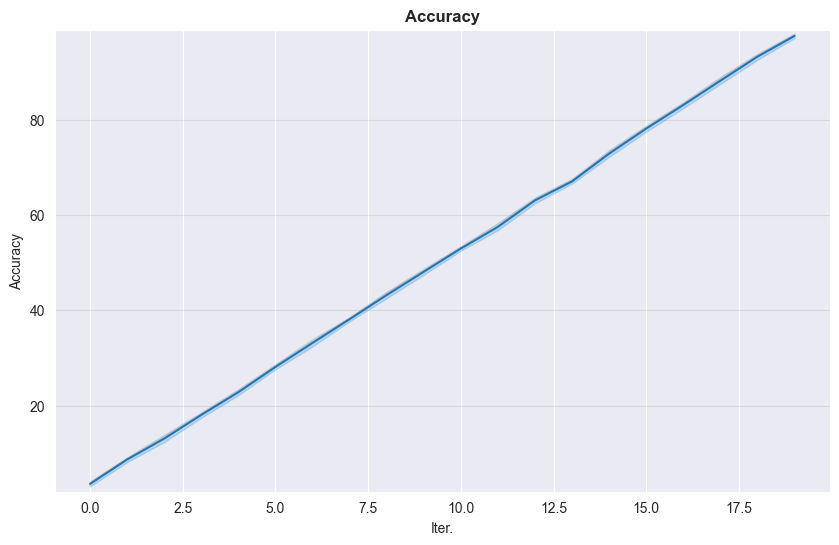

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Accuracy", fontweight='bold')

ax.set_ylim(min(sns_test_df["accuracy"]), max(sns_test_df["accuracy"]))
    
sns.lineplot(ax=ax,
             data=sns_test_df,
             x="iter",
             y="accuracy")

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Accuracy")

plt.show()

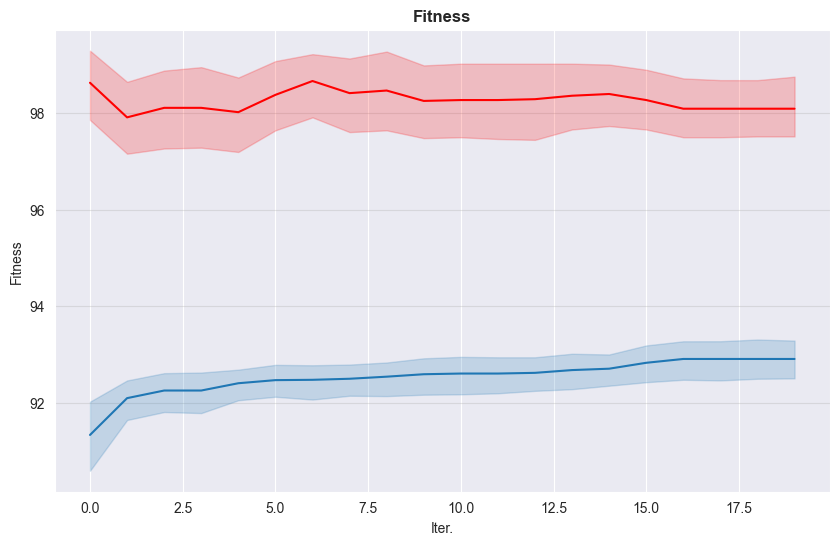

In [22]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Fitness", fontweight='bold')


#ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=global_train_hist,
             x="Iteration",
             y="Fitness")

sns.lineplot(ax=ax,
             data=global_train_hist,
             x="Iteration",
             y="Accuracy", color="red")

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Fitness")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

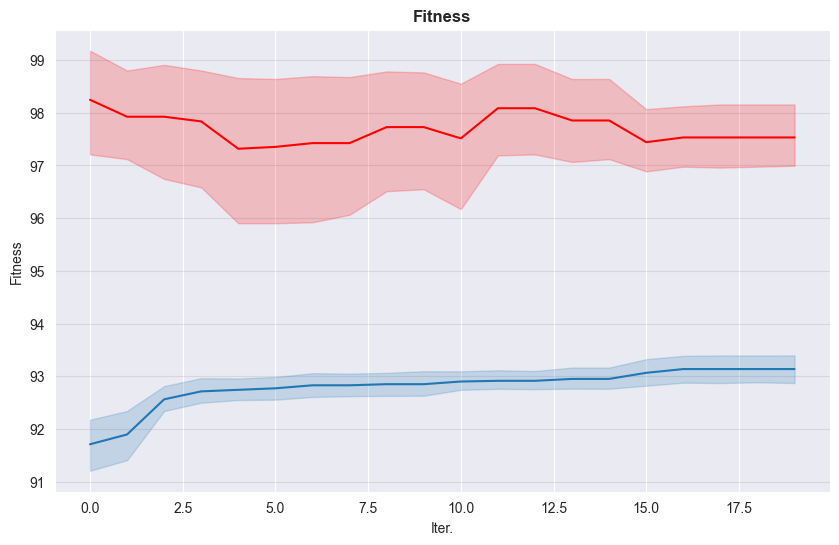

In [20]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Fitness", fontweight='bold')


#ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=global_train_hist,
             x="Iteration",
             y="Fitness")

sns.lineplot(ax=ax,
             data=global_train_hist,
             x="Iteration",
             y="Accuracy", color="red")

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Fitness")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

In [22]:
global_train_hist.groupby("run")

In [89]:
previous_history = gsa_history_dict["accuracy_history"]

In [91]:
# SB T-test results (with and without Chaotic constant)
from scipy import stats as st

st.ttest_ind(previous_history, gsa_history_dict["accuracy_history"])

TtestResult(statistic=-1.228456351135857, pvalue=0.2350961953092592, df=18.0)

In [89]:
previous_history = gsa_history_dict["accuracy_history"]

In [91]:
# MR T-test results (with and without Chaotic constant)
from scipy import stats as st

st.ttest_ind(previous_history, gsa_history_dict["accuracy_history"])

TtestResult(statistic=-1.228456351135857, pvalue=0.2350961953092592, df=18.0)

In [82]:
previous_history = gsa_history_dict["accuracy_history"]

In [85]:
# BC T-test results (with and without Chaotic constant)
from scipy import stats as st

st.ttest_ind(previous_history, gsa_history_dict["accuracy_history"])

TtestResult(statistic=0.30738931174714285, pvalue=0.7620751630156236, df=18.0)

In [77]:
mean_accuracy = np.round(np.mean(gsa_history_dict["accuracy_history"]), 4)
std_accuracy = np.round(np.std(gsa_history_dict["accuracy_history"]), 4)

print(f"Mean accuracy: {mean_accuracy} +/- {std_accuracy}")

mean_gamma = np.round(np.mean(gsa_history_dict["gamma_history"]), 4)
std_gamma = np.round(np.std(gsa_history_dict["gamma_history"]), 4)

print(f"Mean gamma: {mean_gamma} +/- {std_gamma}")

mean_c = np.round(np.mean(gsa_history_dict["c_history"]), 4)
std_c = np.round(np.std(gsa_history_dict["c_history"]), 4)

print(f"Mean C: {mean_c} +/- {std_c}")

mean_n_features = np.rint(np.mean(gsa_history_dict["n_features_history"])).astype(int)
std_n_features = np.rint(np.std(gsa_history_dict["n_features_history"])).astype(int)

print(f"Mean n_features: {mean_n_features} +/- {std_n_features}")

mean_execution_time = np.round(np.mean(gsa_history_dict["execution_time_history"]), 4)
std_execution_time = np.round(np.std(gsa_history_dict["execution_time_history"]), 4)

print(f"Mean execution time: {mean_execution_time} +/- {std_execution_time}")

mean_TP = np.rint(np.mean(gsa_history_dict["TP_history"])).astype(int)
std_TP = np.rint(np.std(gsa_history_dict["TP_history"])).astype(int)
mean_FP = np.rint(np.mean(gsa_history_dict["FP_history"])).astype(int)
std_FP = np.rint(np.std(gsa_history_dict["FP_history"])).astype(int)
mean_TN = np.rint(np.mean(gsa_history_dict["TN_history"])).astype(int)
std_TN = np.rint(np.std(gsa_history_dict["TN_history"])).astype(int)
mean_FN = np.rint(np.mean(gsa_history_dict["FN_history"])).astype(int)
std_FN = np.rint(np.std(gsa_history_dict["FN_history"])).astype(int)

Mean accuracy: 94.0717 +/- 0.8943
Mean gamma: 0.0074 +/- 0.0022
Mean C: 70.132 +/- 23.8854
Mean n_features: 29 +/- 3
Mean execution time: 19.4743 +/- 0.7857


In [78]:
import datetime

save_path = "../data/output"
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

results = pd.DataFrame({"date": [date],
                        "dataset_name": [widget_opt.value],
                        "r_runs": [runs],
                        "n_pop": [population_size],
                        "n_iters": [iterations],
                        "chaotic_constant": [chaotic_constant],
                        "repair_solution": [repair_solution],
                        "execution_time": [mean_execution_time],
                        "execution_time_std": [std_execution_time],
                        "wa": [wa],
                        "wf": [wf],
                        "mean_accuracy": [mean_accuracy],
                        "std_accuracy": [std_accuracy],
                        "mean_gamma": [mean_gamma],
                        "std_gamma": [std_gamma],
                        "mean_c": [mean_c],
                        "std_c": [std_c],
                        "mean_n_features": [mean_n_features],
                        "std_n_features": [std_n_features],
                        "TP": [mean_TP],
                        "TP_std": [std_TP],
                        "FP": [mean_FP],
                        "FP_std": [std_FP],
                        "TN": [mean_TN],
                        "TN_std": [std_TN],
                        "FN": [mean_FN],
                        "FN_std": [std_FN]})

file = f"{save_path}/gsa_records.csv"
if os.path.exists(file):
    # Load dataframe and append new row
    df = pd.read_csv(file)
    df = pd.concat([df, results], axis=0, ignore_index=True)
    df.to_csv(file, index=False)
else: # Append row to existing file
    results.to_csv(file, index=False)

                /\ 
               /  \
                || 
                
        Nuestros resultados
        
Dataset: Mushroom
Instances: 8124 (Train / Test: 80% / 20%)
Features: 22

Resultados autores:

| Metric | Value             |
| --- |-------------------|
| Accuracy | 98.06 +/- 0.78    |
| Gamma | 0.0067 +/- 0.0144 |
| C | 47.35 +/- 27.57   |
| n_features | 3 +/- 2.16        |

                /\ 
               /  \
                || 
                
        Nuestros resultados
        
Dataset: Breast Cancer Wisconsin (Diagnostic) Data Set

Resultados autores:

| Metric | Value             |
| --- |-------------------|
| Accuracy | 99.54 +/- 0.25    |
| Gamma | 0.0685 +/- 0.1293 |
| C | 40.30 +/- 22.37   |
| n_features | 2 +/- 1           |